## Import modules

In [ ]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np

## LOAD DATABASES, CONCATENATE AND MIX THEM

In [60]:
rv = [10., 15., 20., 25., 30., 35., 40., 46., 50., 54., 60.]
nr = len(rv)
paths = []
for r in rv:
    paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")

n_traj = 50000
db = np.ndarray(shape=(nr*n_traj,2000,1))
labels = []
for path,r,i in zip(paths,rv,range(nr)):
    db1 = np.load(path)
    for j in range(n_traj):
        db[i*n_traj + j,:,0] = db1[j,0,:]
        labels.append(r)

labels = np.array(labels)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

db, labels = unison_shuffled_copies(db, labels)

## CONVERTO LABELS PER DEFINIRE LE CLASSI

In [61]:
ll = []
for label in labels :
    if label in rv :
        ll.append(rv.index(label))
    else: print('problem')
labels = ll

## PREPROCESSING

In [62]:
db = db[:,:,0:1]
print(db.shape)
M = np.max(db)
m = np.min(db)
print(f'actual max and min: {M:.2f} and {m:.2f}')
#M = 33.45311378674468 # max and min among 10 20 30 40 50 60 databases
#m = -33.45763272036239
db = (db - m)/(M - m)
M = np.max(db)
m = np.min(db)

print(M,m)

(550000, 2000, 1)
actual max and min: 33.45 and -33.46
1.0 0.0


## VISUALIZE DATA

7684
40.0


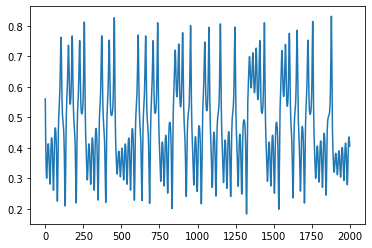

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n = round(np.random.uniform(50000))
#n = 35368
print(n)
traj = db[n,:,:]
print(rv[labels[n]])
plt.plot(traj[:,0])
#plt.plot(traj[:,1])
#plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

## ARCHITETTURA RETE NEURALE

In [70]:
opt = Adam(0.00008)#, 0.5)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
sigma_init = 0.02 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.
def create_desc():
    discriminator = Sequential()
    #input:2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #input:250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #input:32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))
    #input:8x8
    #input:2000x1
    #discriminator.add(Conv1D(2, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #input:250x8
    #discriminator.add(Conv1D(2, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #input:32x8
    #discriminator.add(Conv1D(4, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))
    #discriminator.add(Conv1D(4, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #input:250x8
    #discriminator.add(Conv1D(6, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #input:32x8
    #discriminator.add(Conv1D(6, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))
    #discriminator.add(Conv1D(8, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #input:250x8
    #discriminator.add(Conv1D(8, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #input:32x8
    discriminator.add(Flatten())
    #8000x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #discriminator.add(Dropout(0.1))
    discriminator.add(Dense(11, activation='softmax'))
    #discriminator.add(Dropout(0.1))
    #4x1
    discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return discriminator

desc = create_desc()

In [71]:
desc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 250, 8)            168       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 8)             1288      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 8)              1288      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                715       
Total params: 7,619
Trainable params: 7,619
Non-trainable params: 0
____________________________________________________

# TRAINING

In [72]:
#desc = create_desc()
fit_history = desc.fit(db, labels, batch_size=256, epochs=70, verbose=1, validation_split=0.33,
                       shuffle=False)#, callbacks=[history])

Train on 368499 samples, validate on 181501 samples
Epoch 1/70
368499/368499 [==============================] - 13s 36us/sample - loss: 1.6515 - acc: 0.4106 - val_loss: 1.0397 - val_acc: 0.6123
Epoch 2/70
368499/368499 [==============================] - 16s 44us/sample - loss: 0.8939 - acc: 0.6586 - val_loss: 0.7858 - val_acc: 0.6946
Epoch 3/70
368499/368499 [==============================] - 16s 44us/sample - loss: 0.7304 - acc: 0.7098 - val_loss: 0.6680 - val_acc: 0.7188
Epoch 4/70
368499/368499 [==============================] - 16s 44us/sample - loss: 0.6291 - acc: 0.7538 - val_loss: 0.5750 - val_acc: 0.7864
Epoch 5/70
368499/368499 [==============================] - 16s 43us/sample - loss: 0.5378 - acc: 0.8010 - val_loss: 0.4861 - val_acc: 0.8312
Epoch 6/70
368499/368499 [==============================] - 15s 39us/sample - loss: 0.4501 - acc: 0.8468 - val_loss: 0.3989 - val_acc: 0.8784
Epoch 7/70
368499/368499 [==============================] - 14s 39us/sample - loss: 0.3709 - acc

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


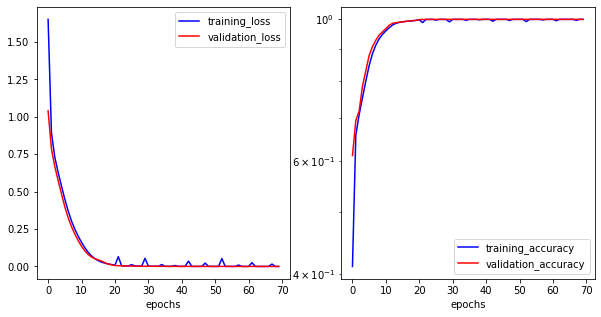

In [74]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
#epoch = fit_history.history
epoch = fit_history.history
ax1.set_xlabel("epochs")
ax2.set_xlabel("epochs")
plt.yscale('log')
ax1.plot(epoch['loss'], color="b",label="training_loss")
ax1.plot(epoch['val_loss'], color="r",label="validation_loss")
ax1.legend()
ax2.plot(epoch['acc'], color="b",label="training_accuracy")
ax2.plot(epoch['val_acc'], color="r",label="validation_accuracy")
ax2.legend()
plt.savefig('prova', dpi=220, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [73]:
#desc.save('classificatore_10_15_20_15_30_35_40_46_50_54_60.h5')
#from tensorflow.keras.models import load_model
#desc = load_model('classificatore_20_22.5_26_27.5.h5')

# TESTING

In [58]:
#desc.evaluate(db,labels)
#desc.evaluate(db,np.array([2]*50000))
aaa = desc.predict(db)

In [59]:
classes = np.array([0., 1., 2., 3., 4., 5.])
mm = 0.
for aa in aaa:
    mm += np.dot(aa,classes)
mm /= len(aaa)
mm /= 5.
print(10. + mm*50.)

46.335756607334915


In [36]:
a = []
for aa in aaa:
    a.append(aa[1])
np.mean(a)

0.38382506

## ANALISI PESI 

In [12]:
a = desc.get_weights()
for i in range(8): 
    print( a[i].shape )

(10, 1, 8)
(8,)
(10, 8, 8)
(8,)
(10, 8, 8)
(8,)
(64, 64)
(64,)


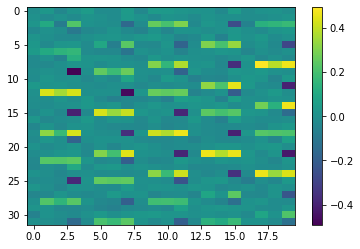

In [18]:
ciccio = a[2].reshape(32,-1)
import matplotlib.pyplot as plt
plt.imshow(ciccio, aspect="auto")
plt.colorbar()